In [1]:
MAKE_BOOK_FIGURES=True

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

# Multivariate Gaussian Process Regression

We perform multivariate Gaussian process regression with automatic relevance determination.
When we say "multivariate" here, we refer to many function inputs, not outputs.
This means that the input of the function we are interested in learning is a vector $\mathbf{x}$ in $\mathbb{R}^D$.
Nothing changes compared to one-input GPR.
The formulas are the same.
However, in higher dimensional settings, one must pay attention to selecting the covariance function.

Let's demonstrate this using an example.
Here is an analytical function known as the Branin-Hoo function:

$$
f(\mathbf{x}) = f(x_1,x_2) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right]
$$

Here $\mathbf{x} = (x_1, x_2)$ and it takes values in $[0,1]^2$.
We will use this function to generate some synthetic data.
Let's superimpose the synthetic data on a contour of this function.

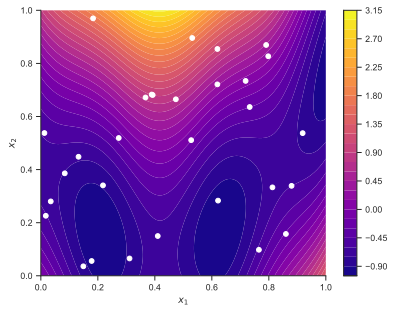

In [2]:
# Define the function
def f_branin(x):
    """Input must be 2D array of size N x 2."""
    return (
        1.0 / 51.95
        * (
            (
                15.0 * x[:, 1]
                - 5.1 * (
                    (15.0 * x[:, 0]) ** 2
                    / (4.0 * np.pi ** 2)
                )
                + 75.0 * x[:, 0] / np.pi
                - 6.0
            ) ** 2
            + (
                (10.0 - 10.0 / (8.0 * np.pi))
                * np.cos(15.0 * x[:, 0])
            )
            - 44.81
        )
    )


N = 30
Xdata = np.random.rand(N, 2)
sigma = 0.01
Ydata = f_branin(Xdata) + sigma * np.random.randn(N)

fig = plt.figure()
ax = plt.subplot(111)
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
Xs = np.vstack([X1.flatten(), X2.flatten()]).T
Y = f_branin(Xs).reshape((100, 100))

c = ax.contourf(X1, X2, Y, 30, cmap='plasma')
plt.colorbar(c)
ax.plot(
    Xdata[:, 0],
    Xdata[:, 1],
    'o',
    color='white'
)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True)

You may need to install gpytorch:

In [ ]:
!pip install gpytorch

And we also need the function that trains the model:

In [12]:
def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()

We will be using a the squared exponential covariance function for a regression along with a constant mean.
So our prior GP is:

$$
f(\cdot)\sim\operatorname{GP}(0, k(\cdot,\cdot)),
$$

with

$$
k(\mathbf{x}, \mathbf{x}') = s^2\exp\left(-\frac{(x_1-x_1')^2}{2\ell_1^2}-\frac{(x_2-x_2')^2}{2\ell_2^2}\right).
$$

The first, situation we are going to examin is when the lengthscales are the same:

$$
\ell_1 = \ell_2.
$$

To save ourselves some coding, we are going to make the `ExactGP` model class a bit more general.
We will make it accept a covariance function as a constructor argument.

In [13]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

class ExactGP(gpytorch.models.ExactGP):
    """Exact Gaussian Process model.

    Arguments
    train_x     --  The training inputs.
    train_y     --  The training labels.
    mean_module --  The mean module. Defaults to a constant mean.
    covar_module--  The covariance module. Defaults to a RBF kernel.
    likelihood  --  The likelihood function. Defaults to Gaussian.
    """

    def __init__(
            self,
            train_x,
            train_y,
            mean_module=gpytorch.means.ConstantMean(),
            covar_module = ScaleKernel(RBFKernel()),
            likelihood=gpytorch.likelihoods.GaussianLikelihood(
                noise_constraint=gpytorch.constraints.GreaterThan(0.0)
            )
    ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Here is how to use it with the default options:

In [14]:
train_x = torch.from_numpy(Xdata).float()
train_y = torch.from_numpy(Ydata).float()
model = ExactGP(train_x, train_y)

Optimize the hyper-parameters:

In [15]:
train(model, train_x, train_y, n_iter=10)

Iter   1/10 - Loss: 1.046
Iter   2/10 - Loss: -0.078
Iter   3/10 - Loss: -0.078
Iter   4/10 - Loss: -0.078
Iter   5/10 - Loss: -0.078
Iter   6/10 - Loss: -0.078
Iter   7/10 - Loss: -0.078
Iter   8/10 - Loss: -0.078
Iter   9/10 - Loss: -0.078
Iter  10/10 - Loss: -0.078


Check the lengthscales:

In [19]:
print(f"mean constant:\t{model.mean_module.constant.item():.3f}")
print(f"output scale:\t{model.covar_module.outputscale.item():.3f}")
print(f"length scale:\t{model.covar_module.base_kernel.lengthscale.item():.3f}")
print(f"noise:\t\t{model.likelihood.noise.item():.3f}")

mean constant:	0.081
output scale:	0.672
length scale:	0.236
noise:		0.001


Make predictions:

In [21]:
fpred_flat = model(torch.from_numpy(Xs).float())
Ypred_flat = fpred_flat.mean.detach().numpy()
Yvar_flat = model.likelihood(fpred_flat).variance.detach().numpy()

Plot predictions:

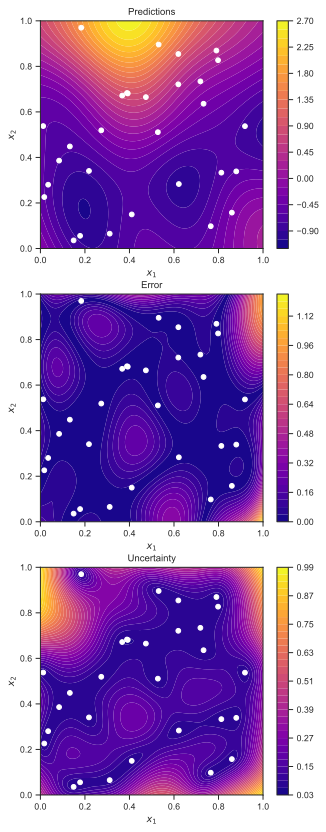

In [22]:
fig, ax = plt.subplots(3,1, figsize=(5, 14))

Ypred = Ypred_flat.reshape((100, 100))
im = ax[0].contourf(X1, X2, Ypred, 30, cmap='plasma')
c = plt.colorbar(im, ax=ax[0])
ax[0].plot(
    Xdata[:, 0],
    Xdata[:, 1],
    'o',
    color='white'
)
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].set_title('Predictions')

# Error
E = np.abs(Y - Ypred)
im = ax[1].contourf(X1, X2, E, 30, cmap='plasma')
ax[1].plot(
    Xdata[:, 0],
    Xdata[:, 1],
    'o',
    color='white'
)
c = plt.colorbar(im, ax=ax[1])
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
ax[1].set_title('Error')

# Uncertainty
im = ax[2].contourf(
    X1,
    X2,
    2.0 * np.sqrt(Yvar_flat.reshape(X1.shape)),
    30,
    cmap='plasma'
)
ax[2].set_title('Uncertainty')
c = plt.colorbar(im, ax=ax[2])
ax[2].plot(
    Xdata[:, 0],
    Xdata[:, 1],
    'o',
    color='white'
)
ax[2].set_xlabel('$x_1$')
ax[2].set_ylabel('$x_2$');

Let's get some test data and make some predictions.

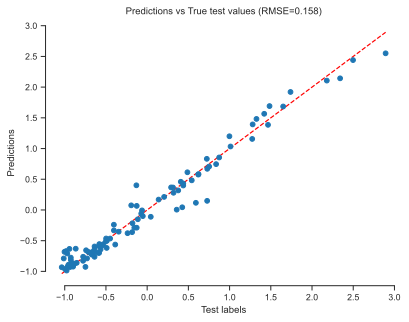

In [23]:
from sklearn.metrics import mean_squared_error

Ntest = 100
Xtest = np.random.rand(Ntest, 2)
Ytest = f_branin(Xtest) + sigma * np.random.randn(Ntest)
ftest = model(torch.from_numpy(Xtest).float())
Ytest_m = ftest.mean.detach().numpy()
Ytest_v = model.likelihood(ftest).variance.detach().numpy()
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig, ax = plt.subplots()
ys = np.linspace( np.min(Ytest), np.max(Ytest), 100 )
ax.plot(ys, ys, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title(f'Predictions vs True test values (RMSE={error_m:.3f})')
ax.set_xlabel('Test labels')
ax.set_ylabel('Predictions')
sns.despine(trim=True);

Now let's repeat the same analysis but allowing for a different lengthscale per input.
First, we set up and train the model:

In [24]:
model = ExactGP(
    train_x,
    train_y,
    covar_module=ScaleKernel(RBFKernel(ard_num_dims=2))
)


And you can train the model as usual:

In [25]:
train(model, train_x, train_y, n_iter=10)

Iter   1/10 - Loss: 11.799
Iter   2/10 - Loss: -0.546
Iter   3/10 - Loss: -0.546
Iter   4/10 - Loss: -0.546
Iter   5/10 - Loss: -0.546
Iter   6/10 - Loss: -0.546
Iter   7/10 - Loss: -0.546
Iter   8/10 - Loss: -0.546
Iter   9/10 - Loss: -0.546
Iter  10/10 - Loss: -0.546


And here are the parameters we found:

In [26]:
print(f"mean constant:\t{model.mean_module.constant.item():.3f}")
print(f"output scale:\t{model.covar_module.outputscale.item():.3f}")
for i in range(2):
    print(f"length scale {i}:\t{model.covar_module.base_kernel.lengthscale[0, i].item():.3f}")
print(f"noise:\t\t{model.likelihood.noise.item():.3f}")

mean constant:	2.134
output scale:	5.979
length scale 0:	0.253
length scale 1:	0.966
noise:		0.000


The length scale assigned to $ x_1 $ is slightly smaller than that given to $ x_2 $. This means the first input is more important than the second one.
This is the automatic relevance determination (ARD) in action.

Now, let's make some predictions with the ARD version of the GP regression model.

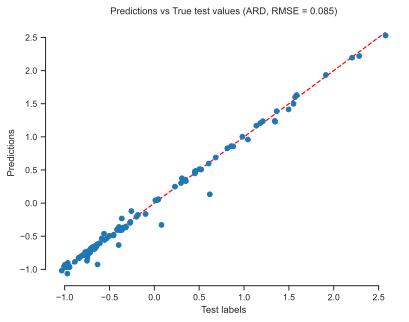

In [27]:
Ntest = 100
Xtest = np.random.rand(Ntest, 2)
Ytest = f_branin(Xtest) + sigma * np.random.randn(Ntest)
ftest = model(torch.from_numpy(Xtest).float())
Ytest_m = ftest.mean.detach().numpy()
Ytest_v = model.likelihood(ftest).variance.detach().numpy()
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig, ax = plt.subplots()
ys = np.linspace( np.min(Ytest), np.max(Ytest), 100 )
ax.plot(ys, ys, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title(f'Predictions vs True test values (ARD, RMSE = {error_m:.3f})')
ax.set_xlabel('Test labels')
ax.set_ylabel('Predictions')
sns.despine(trim=True);

The RMSE in much smaller than the previous case. And the parity plot shows that the predictions are much better.

Let's add a third dimension to the Branin function, $x_3$, such that $f$ has a weak linear dependence on $x_3$. 
The new function is:

$$
f(\mathbf{x}) = f(x_1,x_2, x_3) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right] +\color{blue}{0.1 x_3}.
$$

Here is the code:

In [28]:
def f_branin_1(x):
    """
    Input must be 2D array of size N x 2.
    """
    return f_branin(x) + 0.1*x[:, 2]

Let's generate some synthetic data and train a GP model with ARD. Let's see if we can discover the weak dependence of $f$ on the newly added 3rd dimension. 

In [29]:
N    = 40
ndim = 3
Xdata = np.random.rand(N, ndim)

sigma = 0.01
Ydata = f_branin_1(Xdata) + sigma * np.random.randn(N)

Train a GP:

In [30]:
train_x = torch.from_numpy(Xdata).float()
train_y = torch.from_numpy(Ydata).float()
model = ExactGP(
    train_x,
    train_y,
    covar_module=ScaleKernel(RBFKernel(ard_num_dims=ndim))
)
train(model, train_x, train_y, n_iter=10)

Iter   1/10 - Loss: 15.501
Iter   2/10 - Loss: -0.977
Iter   3/10 - Loss: -0.982
Iter   4/10 - Loss: -0.982
Iter   5/10 - Loss: -0.982
Iter   6/10 - Loss: -0.982
Iter   7/10 - Loss: -0.982
Iter   8/10 - Loss: -0.982
Iter   9/10 - Loss: -0.982
Iter  10/10 - Loss: -0.982


Here are the results:

In [32]:
print(f"mean constant:\t{model.mean_module.constant.item():.3f}")
print(f"output scale:\t{model.covar_module.outputscale.item():.3f}")
for i in range(ndim):
    print(f"length scale {i}:\t{model.covar_module.base_kernel.lengthscale[0, i].item():.3f}")
print(f"noise:\t\t{model.likelihood.noise.item():.3f}")

mean constant:	2.896
output scale:	8.075
length scale 0:	0.254
length scale 1:	1.064
length scale 2:	47.006
noise:		0.000


Notice from the results above that the length scale of the 3rd dimension is enormous relative to the length scales along the 1st and 2nd dimensions. 
This means that our trained GP model depends very weakly on $x_3$. We can capture the weak dependence of $f$ on $x_3$. 

Let's make some predictions on the test data:

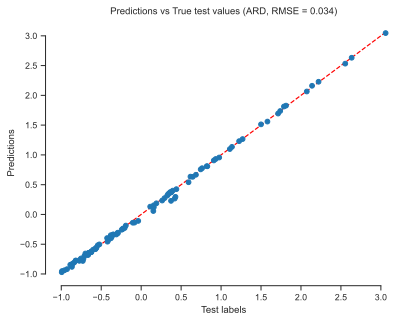

In [35]:
Ntest = 100
Xtest = np.random.rand(Ntest, ndim)
Ytest = f_branin_1(Xtest) + sigma * np.random.randn(Ntest)
ftest = model(torch.from_numpy(Xtest).float())
Ytest_m = ftest.mean.detach().numpy()
Ytest_v = model.likelihood(ftest).variance.detach().numpy()
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig, ax = plt.subplots()
ys = np.linspace( np.min(Ytest), np.max(Ytest), 100 )
ax.plot(ys, ys, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title(f'Predictions vs True test values (ARD, RMSE = {error_m:.3f})')
ax.set_xlabel('Test labels')
ax.set_ylabel('Predictions')
sns.despine(trim=True);

Now let's add a fourth dimension to the Branin function, $x_4$, such that $f(x_1, x_2, x_3, x_4) = f(x_1, x_2, x_3)$, i.e., $f$ does not actually depend on $x_4$. 

$$
f(\mathbf{x}) = f(x_1,x_2, x_3, x_4) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right] + \color{blue}{0.1 x_3}.
$$

In [36]:
# define the function
def f_branin_2(x):
    assert x.shape[1] == 4, 'The input should be 4 dimensional.'
    return f_branin_1(x[:, :3])

Generate synthetic data:

In [37]:
N    = 40
ndim = 4
Xdata = np.random.rand(N, ndim)

sigma = 0.01
Ydata = f_branin_2(Xdata) + sigma * np.random.randn(N)

Train a GP:

In [39]:
train_x = torch.from_numpy(Xdata).float()
train_y = torch.from_numpy(Ydata).float()
model = ExactGP(
    train_x,
    train_y,
    covar_module=ScaleKernel(RBFKernel(ard_num_dims=ndim))
)
train(model, train_x, train_y, n_iter=10)

print(f"mean constant:\t{model.mean_module.constant.item():.3f}")
print(f"output scale:\t{model.covar_module.outputscale.item():.3f}")
for i in range(ndim):
    print(f"length scale {i}:\t{model.covar_module.base_kernel.lengthscale[0, i].item():.3f}")
print(f"noise:\t\t{model.likelihood.noise.item():.3f}")

Iter   1/10 - Loss: 7.194
Iter   2/10 - Loss: -0.798
Iter   3/10 - Loss: -0.862
Iter   4/10 - Loss: -0.862
Iter   5/10 - Loss: -0.862
Iter   6/10 - Loss: -0.862
Iter   7/10 - Loss: -0.862
Iter   8/10 - Loss: -0.862
Iter   9/10 - Loss: -0.862
Iter  10/10 - Loss: -0.862
mean constant:	2.669
output scale:	6.715
length scale 0:	0.249
length scale 1:	0.960
length scale 2:	49.234
length scale 3:	43.728
noise:		0.000


Notice that $\ell_4$ is also very large.
The ARD training procedure discovers that the dependence of the function $f$ is very weak in the input $x_4$ as well.

Now let's make some predictions and compare it to the test observations.

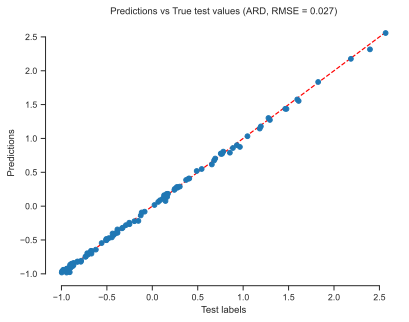

In [40]:
Ntest = 100
Xtest = np.random.rand(Ntest, ndim)
Ytest = f_branin_1(Xtest) + sigma * np.random.randn(Ntest)
ftest = model(torch.from_numpy(Xtest).float())
Ytest_m = ftest.mean.detach().numpy()
Ytest_v = model.likelihood(ftest).variance.detach().numpy()
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig, ax = plt.subplots()
ys = np.linspace( np.min(Ytest), np.max(Ytest), 100 )
ax.plot(ys, ys, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title(f'Predictions vs True test values (ARD, RMSE = {error_m:.3f})')
ax.set_xlabel('Test labels')
ax.set_ylabel('Predictions')
sns.despine(trim=True);

## Questions:
For the very last example (4D):
+ Add code cells above that compute the standardized errors and do the quantile-quantile plots.
+ Experiment with a tiny number of samples $N$. What happens?
+ Experiment with many samples, say $N = 500$. What happens?